In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import pandas_datareader as pdr

In [2]:
start='2015-01-01'
end= date.isoformat(date.today())


In [3]:
dataset=pdr.DataReader('AAPL','yahoo',start,end)

In [4]:
dataset=dataset.reset_index()

In [5]:
dataset=dataset.drop(['Date','Adj Close'],axis=1)

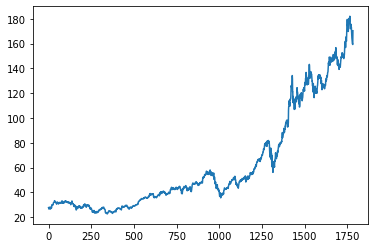

In [6]:
plt.plot(dataset.Close)

In [7]:
#moving avg 100
mv100=dataset.Close.rolling(100).mean()
mv200=dataset.Close.rolling(200).mean()

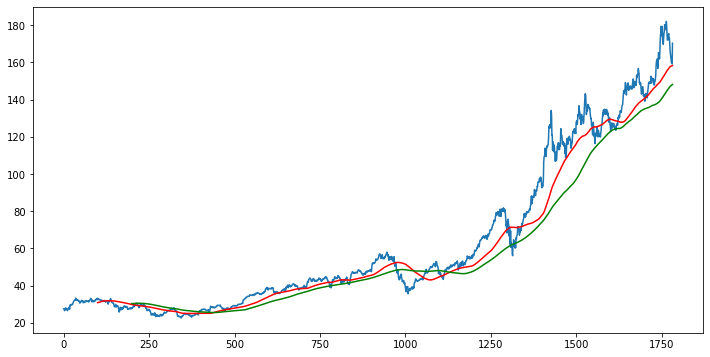

In [8]:
#plotting the moving average 100
plt.figure(figsize=(12,6))
plt.plot(dataset.Close)
plt.plot(mv100,'r')
plt.plot(mv200,'g')

In [9]:
dataset.shape

(1783, 5)

In [10]:
training_set= pd.DataFrame(dataset["Close"][0:int(len(dataset)*.70)])
testing_set= pd.DataFrame(dataset["Close"][int(len(dataset)*.70): int(len(dataset))])

In [11]:
training_set.shape

(1248, 1)

In [12]:
#remember that for LSTM model we have to ensure that the data is scaled between 0&1
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
dt_train_sc=sc.fit_transform(training_set)

In [60]:
x_train=[]
y_train=[]
for i in range(70,dt_train_sc.shape[0]):
    x_train.append(dt_train_sc[i-70:i])
    y_train.append(dt_train_sc[i,0])
x_train,y_train=np.array(x_train),np.array(y_train)
x_train.shape

(1178, 70, 1)

In [61]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

In [62]:
#defining the model
regressor=Sequential()
regressor.add(LSTM(units=50,activation='relu',return_sequences=True,input_shape=(x_train.shape[1],1)))
regressor.add(Dropout(0.3))
#units refer to as to how many such units have to be made more or like 3rd dimension
regressor.add(LSTM(units=60,activation='relu',return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80,activation='relu',return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=120,activation='relu'))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=25))
regressor.add(Dense(units=1))

In [63]:
regressor.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 70, 50)            10400     
                                                                 
 dropout_16 (Dropout)        (None, 70, 50)            0         
                                                                 
 lstm_17 (LSTM)              (None, 70, 60)            26640     
                                                                 
 dropout_17 (Dropout)        (None, 70, 60)            0         
                                                                 
 lstm_18 (LSTM)              (None, 70, 80)            45120     
                                                                 
 dropout_18 (Dropout)        (None, 70, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

In [64]:
regressor.compile(optimizer='adam',loss='mean_squared_error') #adam is the optimizer generally used for big data
#loss gives more or less the acuuray of the model or the loss of data in each cycle of training
#training the model
import tensorflow as tf
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3,restore_best_weights=True)
regressor.fit(x_train,y_train,epochs=60,batch_size=32,callbacks=[callback])

Epoch 1/60
37/37 [==============================] - 9s 151ms/step - loss: 0.0411
Epoch 2/60
37/37 [==============================] - 6s 155ms/step - loss: 0.0077
Epoch 3/60
37/37 [==============================] - 6s 150ms/step - loss: 0.0050
Epoch 4/60
37/37 [==============================] - 6s 155ms/step - loss: 0.0049
Epoch 5/60
37/37 [==============================] - 6s 158ms/step - loss: 0.0048
Epoch 6/60
37/37 [==============================] - 6s 152ms/step - loss: 0.0040
Epoch 7/60
37/37 [==============================] - 5s 149ms/step - loss: 0.0040
Epoch 8/60
37/37 [==============================] - 6s 149ms/step - loss: 0.0039
Epoch 9/60
37/37 [==============================] - 6s 149ms/step - loss: 0.0034
Epoch 10/60
37/37 [==============================] - 6s 149ms/step - loss: 0.0032
Epoch 11/60
37/37 [==============================] - 6s 149ms/step - loss: 0.0032
Epoch 12/60
37/37 [==============================] - 6s 150ms/step - loss: 0.0028
Epoch 13/60
37/37 [======

In [65]:
sc_test=MinMaxScaler(feature_range=(0,1))
prev_data=training_set.tail(70)
f_test=prev_data.append(testing_set,ignore_index=True)
f_test_sc=sc_test.fit_transform(f_test)

In [66]:
x_test=[]
y_test=[]
for i in range(70,f_test_sc.shape[0]):
    x_test.append(f_test_sc[i-70:i])
    y_test.append(f_test_sc[i])
x_test,y_test=np.array(x_test),np.array(y_test)


In [67]:
#predicting the data

y_predicted= regressor.predict(x_test)

In [68]:
y_test=sc_test.inverse_transform(y_test)
y_predicted=sc_test.inverse_transform(y_predicted)


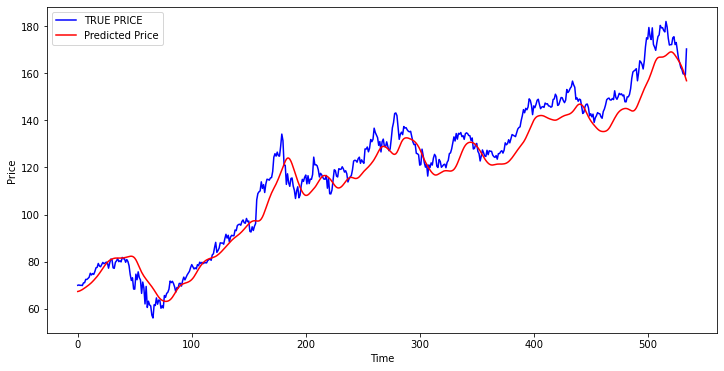

In [69]:
plt.figure(figsize=(12,6))
plt.plot(y_test,'b',label="TRUE PRICE")
plt.plot(y_predicted,'r',label="Predicted Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()

In [70]:
regressor.save('stock_model1.h5')